In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
import random
from random import randint
import math

In [1]:
food_amount = 50
pacman_amount = 200
board_size = 1000
default_health = 50
pacmen = []
food = []
crot = 1
cloc = .5
cbite = 1
turn_loss = 200
phi_prec = (80/255.)
alpha_prec = 10/255.
delta_prec = 10/255.
pacman_radius = 1
food_health = 300
mutation_freq = .005 # percent any 0/1 would flip for each gene

In [144]:
class pacman:
    def __init__(self):
        #change dynamically
        self.x = random.uniform(49*board_size/100,51*board_size/100)
        self.y = random.uniform(49*board_size/100,51*board_size/100)
        #this is set so the prgression will be outward
        self.theta = randint(0,359)
        self.health = default_health
        self.active = 1
        #dna
        self.phi = randint(0,255)
        self.alpha = randint(0,255)
        self.delta = randint(0,255)
        
        self.phi_val = self.phi*phi_prec
        self.alpha_val = self.alpha*alpha_prec
        self.delta_val = self.delta*delta_prec
        #self.f = closest food
        #self.dist = closest food distance
    def __bool__(self):
        return True
    
    def __repr__(self):
        return "{pacman, x:"+str(self.x)+", y:"+str(self.y)+", theta:"+str(self.theta)+"}"
    
    def find_dist(self,f):
        return np.sqrt((self.x-f.x)**2 + (self.y-f.y)**2)
    
    def find_angle(self,f):
        dx = f.x - self.x
        dy = f.y - self.y
        arc = math.degrees(math.atan((dy/dx)))
        theta1 = 1
        if dx > 0:
            theta1 = 180 - arc
            #this used to be an if, but i think arctan returns a negative when a negative is inputted.
            #therefor the two would be equivalent
        else:
            if dy > 0:
                theta1 = np.absolute(arc)
                #this is absolute because the angle will be a negative
            else:
                theta1 = 360 - arc
        #theta1 is the angle the food is from the x axis
        #returned is the difference in the angles
        return np.absolute(theta1 - self.theta)
    
    def check_angle(self,f):#check if the food is in the range
        diff = (self.phi_val/2)#this creates virutal bounds
        f_angle = self.find_angle(f)
        if(f_angle < diff):
            return True
        return False
        
    def find_food(self):
        global food
        closest = False
        closest_dist = False
        for i in food:
            dist = self.find_dist(i)
            if((dist < closest_dist or not closest_dist) and (self.check_angle(i))):
                closest = i
                closest_dist = dist
            self.f = closest
            self.dist = closest_dist
        if(closest != False):
            return True
        return False
        
    def rotate_to_food(self):# returns (in radians!!!) the angle needed to get the food with genetic error
        #no cost to rotation
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        arc = math.atan((dy/dx))
        error = random.uniform(self.alpha_val/-2., self.alpha_val/2.)
        new_theta = arc + error
        return new_theta 
        
    def get_food(self):
        theta = self.rotate_to_food() #warning this is in radians...
        #theta is not used... 
        
        error = random.uniform(self.delta_val/-2., self.delta_val/2.)*0
        new_dist = self.dist + (error*self.dist)
        #the error for distance is relative to the distance, ie the greater the dist the greater the error
        
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        distx = new_dist*(dx/self.dist)#equivalent to cos, error is not associted with the angle yet
        disty = new_dist*(dy/self.dist)#equivalent to sin
        self.x += distx
        self.y += disty
        cost = cloc*new_dist
        self.health -= cost
        #cost of rotate
    
    def bite(self):
        to_food = self.find_dist(self.f)
        self.health -= cbite
        if(to_food < pacman_radius):#means the bite was sucessful
            self.health += food_health
            self.f.reset()
        self.check_bounds()
    def check_bounds(self):
        if(self.x > board_size or self.x < 0):
            self.x = self.x % board_size
        #if(self.x < 0):
        # self.x = board_size + self.x
        if(self.y > board_size or self.y < 0):
            self.y = self.y % board_size
            
            
    
    def random_rotate(self):
        self.theta = randint(0,359)
        #self.health += randint(-2,1)
    
    def step(self):
        self.health -= turn_loss
        if(self.find_food()):
            self.get_food()
            self.bite()
        self.random_rotate()
    
    
    def get_genes(self):
        return[self.phi,self.alpha,self.delta]
    
    def set_genes(self,genes):
        self.phi = genes[0]
        self.alpha = genes[1]
        self.delta = genes[2]
        
    def to_bits(self):
        genes = self.get_genes()
        split_genes = []
        for i in genes:
            bin_str = format(i, '#010b')
            bin_str = bin_str[2:]
            split_genes.append([bin_str[:4],bin_str[4:]])
        return split_genes
    def mutate(self, gene):
        #checks each 1/0 and finds a random num and if it below the threshold it mutates
        new_gene = ''
        for i in gene:
            rand = random.uniform(0,1)
            if(rand < mutation_freq):
                #this means the dna is flipping
                num = int(i)
                if(num == 1):
                    num = 0
                else:
                    num = 1
                new_gene += str(num)
            else:
                new_gene += str(i)
                
        return new_gene
        
        
    def reproduce(self,other):
        son1 = pacman()
        son2 = pacman()
        son1_genes = []
        son2_genes = []
        mybits = self.to_bits()
        otherbits = other.to_bits()
        for i,v in enumerate(mybits):
            son1_gene = v[0]+otherbits[i][1]
            son1_gene = self.mutate(son1_gene)
            son2_gene = otherbits[i][0]+v[1]
            son2_gene = self.mutate(son2_gene)
            son1_gene = int('0b'+son1_gene,base=2)
            son2_gene = int('0b'+son2_gene,base=2)
            son1_genes.append(son1_gene)
            son2_genes.append(son2_gene)
        son1.set_genes(son1_genes)
        son2.set_genes(son2_genes)
        return [son1,son2]
        
        
p = pacman()
p2 = pacman()
print(p.reproduce(p2))

[{pacman, x:496.0876640735796, y:499.7720542154919, theta:267}, {pacman, x:491.0193979130969, y:490.0979186938236, theta:110}]


In [145]:
class dot:
    def __init__(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)
        self.active = 1
    def __repr__(self):
        return "{dot, x:"+str(self.x)+", y:"+str(self.y)+"}"
    def reset(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)

In [146]:
def gen1():
    global pacmen
    pacmen = []
    for i in range(0,pacman_amount):
        p = pacman()
        pacmen.append(p)
    pacmen = np.array(pacmen)
    print(pacmen[0])
    return pacmen

def food1():
    global food
    food = []
    for i in range(0,food_amount):
        f = dot()
        food.append(f)
    food = np.array(food)
    return food

def reproduce1(healthy_pacmen):# takes an array of pacmen and reproduces each with a neibor
    #inactive for now
    sons = []
    for i,v in enumerate(healthy_pacmen):
        if( i % 2 == 1):
            temp = v.reproduce(healthy_pacmen[randint(0,len(healthy_pacmen)-1)])
            sons.extend(temp)
    return sons

def find_average_health(p,x=10): #takes an array of pacmen and finds the averge health
    #it will also sort the pacemen by health and return the helath of the xth pacman
    pacmen_ranked = []
    avg_health = 0
    for i in p:
        pacmen_ranked.append(i.health)
        avg_health += i.health
        
    avg_health = avg_health/len(p)
    pacmen_ranked = np.array(sorted(pacmen_ranked))
    med_health = pacmen_ranked[x]
    print(avg_health, med_health)
    return avg_health, med_health

def reproduce2(healthy_pacmen, x):# takes an array of pacmen and reproduces randomly with other heathy_pacmen
    # x is how many are cut off in the evolution
    sons = []
    total = int(len(healthy_pacmen)/2) + int(x/2) + 1
    for i in range(0,total):
        rand1 = randint(0,len(healthy_pacmen)-1)
        rand2 = randint(0,len(healthy_pacmen)-1)
        p1 = healthy_pacmen[rand1]
        p2 = healthy_pacmen[rand2]
        temp = p1.reproduce(p2)
        sons.extend(temp)
                        
    return sons

def average_genes(p):#phi alpha delta
    avg1 = 0
    avg2 = 0
    avg3 = 0
    for i in p:
        avg1 += i.phi_val
        avg2 += i.alpha_val
        avg3 += i.delta_val
    avg1 = avg1/len(p)
    avg2 = avg2/len(p)
    avg3 = avg3/len(p)
    return avg1,avg2,avg3

In [150]:
def driver(gen,life_span,generations):
    food = food1()
    dt = 1
    t = [0]
    tracker = []
    genetics = [[],[],[]]
    cycles = []
    
    global pacmen
    
    for g in range(0,generations): #iterates through each generation
        tracker.append([])
        avg1,avg2,avg3 = average_genes(pacmen)
        genetics[0].append(avg1)
        genetics[1].append(avg2)
        genetics[2].append(avg3)
        for i in pacmen:
            tracker[g].append([])
            
        cycles.append([])
        t.append(t[-1]+dt)
        for q in range(0,life_span): #runs through time with current generation
            for i,v in enumerate(pacmen):
                tracker[g][i].append([v.x,v.y,v.theta])
                v.step()
            cycles[g].append([])# note cycles starts after the first gen
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            for w in pacmen:
                cycles[g][q][0].append(w.x)
                cycles[g][q][1].append(w.y)
            for f in food:
                cycles[g][q][2].append(f.x)
                cycles[g][q][3].append(f.y)
                
        
        
        #makes the next generation
        x = 150 # number of pacmen dieing
        healthy_pacmen = []
        avg,med = find_average_health(pacmen,x)
        
        for i,v in enumerate(pacmen): #end of a generation mean reproduce
                if(v.health > med):
                    healthy_pacmen.append(v)
        #this system kills off the bottom x pacmen
        
        sons = reproduce2(healthy_pacmen,x)
      
        pacmen = sons
        
    return t,tracker,genetics,cycles

In [151]:
t,tracker,genetics,cycles = driver(gen1(),50,100)#turns then generations

{pacman, x:501.69919874962875, y:503.04798100741584, theta:64}
-3815.31783959 -1946.07189723
-4114.26515099 -2170.5709943
-3975.07799799 -2066.25418381
-3755.50822726 -1965.07109343
-3616.29499599 -1940.77504068
-3690.7968979 -1764.19257586
-3979.0906675 -2056.01912447
-4290.69078857 -2367.4848218
-3981.01642311 -1922.39179312
-3939.6863645 -2026.45407924
-3831.38891081 -2091.44412195
-4214.88162106 -2138.67220278
-4123.21131664 -2127.31361376
-4115.62159417 -2356.05583988
-4050.20590901 -2189.71098325
-4044.40594123 -2186.99227873
-3964.01996906 -2197.61014296
-4180.04978289 -2361.90044096
-4243.15438316 -2421.00200481
-4150.18396519 -2318.55521553
-3809.85711158 -2065.350969
-3971.69653459 -1996.13964536
-3552.08887577 -1925.52879773
-3991.09591077 -2181.82644806
-3785.67042561 -2048.49756536
-3827.66593677 -1806.5455548
-3928.78050089 -1988.74499469
-4307.06487915 -2412.08711557
-4153.43379747 -2145.87077543
-4196.95938929 -2122.30005702
-3754.60283112 -1949.7408634
-3995.66754308 -

[[41.71764705882352, 39.476078431372564, 40.11921568627448, 42.768627450980375, 43.316078431372574, 43.02117647058825, 40.59294117647059, 36.461176470588235, 39.63450980392159, 40.28705882352943, 40.66823529411762, 38.5050980392157, 38.71686274509803, 39.01490196078432, 38.98509803921568, 40.050196078431384, 40.65098039215686, 37.66274509803921, 36.765490196078424, 39.472941176470584, 40.80784313725492, 40.858039215686276, 43.567058823529436, 39.678431372549, 41.992156862745084, 41.6, 39.86196078431373, 39.35529411764709, 40.282352941176505, 39.24392156862746, 42.82352941176471, 37.94039215686273, 40.55999999999999, 38.30274509803923, 39.05882352941177, 40.49568627450981, 38.69490196078431, 37.67529411764707, 39.73333333333334, 42.69333333333334, 39.778823529411746, 39.207843137254905, 39.6878431372549, 39.38352941176469, 40.43450980392157, 38.88784313725487, 41.18117647058821, 40.53803921568626, 38.45176470588237, 41.94509803921568, 42.741960784313754, 41.69725490196079, 37.8964705882

<IPython.core.display.Javascript object>


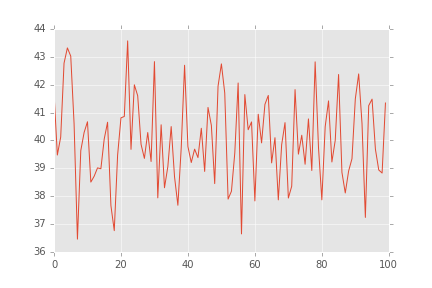

In [152]:
print(genetics)
plt.figure()
plt.plot(genetics[0])# should increase
#plt.plot(genetics[1])#should decrease
#plt.plot(genetics[2])#should decrease
# error is disabled

<IPython.core.display.Javascript object>


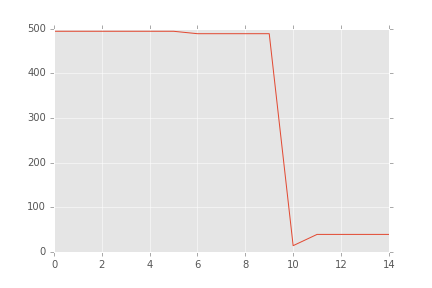

<IPython.core.display.Javascript object>


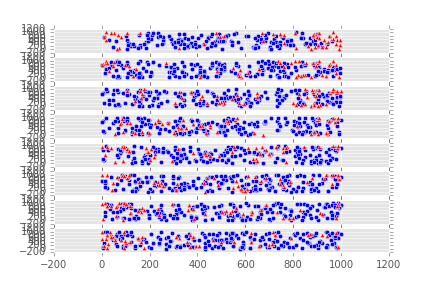

In [119]:
tracker = np.array(tracker)
x = []
for i in tracker[0][0]:
    x.append(i[0])
plt.figure()
plt.plot(x)

figs = 8
gen = 0
f, axarr = plt.subplots(figs, sharex=True,sharey=True)
for i in range(0,figs):
    axarr[i].scatter(cycles[gen][i][0],cycles[gen][i][1])
    axarr[i].scatter(cycles[gen][i][2],cycles[gen][i][3], marker='^',c='red')
    
